# Analysing Global Urban Bus Services using Publicly-Available Routing Data

Authors: [Ed Manley](https://environment.leeds.ac.uk/geography/staff/9293/professor-ed-manley) and [Nick Malleson](http://nickmalleson.co.uk/)

The aim of this work is to analyse public bus transport networks around the world to better understand their importance and impact on society

## Table of Contents

 - [Read Route Metrics Data](#Read-the-Route-Metrics-Data) and [Analysis](#Analysis-of-the-route-city-metrics)
 - [Cluster Analysis](#Cluster-Analysis)
 - The [Implications](#Implications) of the analysis for x


## Initialisation

In [2]:
import os
import pandas as pd
#from sqlalchemy import create_engine
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn import metrics

from IPython.display import Markdown as md # allows markdown printing from python cell

%matplotlib inline
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('seaborn-dark')

## Read the Route Metrics Data

Note that the original data were extracted from XXXX, stored in a local database, and then used to create the CSV files that are read below.

In [15]:
# import data on routes, cities, and subset
route_metrics = pd.read_csv('data/bus_route_metrics.csv')
city_metrics = pd.read_csv('data/city_metrics.csv')

# First subset is all routes except for very short ones. These are used to generat clusters.
subset_cities = []
with open('data/subset_cities.txt') as file:
    for line in file: 
        line = line.strip() 
        subset_cities.append(line)
subset_cities = pd.Series(subset_cities, name='city')
subset_cities = subset_cities.to_frame()

In [16]:
# merge all datasets
route_city_metrics = route_metrics.merge(city_metrics,left_on="location", right_on='city')
route_city_metrics = route_city_metrics.set_index('city').join(subset_cities.set_index('city'), on='city', how='right')
route_city_metrics = route_city_metrics.reset_index(drop=True)

# Extract the name of the city
route_city_metrics['CityName'] = route_city_metrics["city"].apply(lambda x: x.split(',')[0].strip())

In [17]:
len(route_city_metrics)

15130

In [18]:
# filters
route_city_metrics = route_city_metrics[route_city_metrics['route_length'] < 100]
print(len(route_city_metrics))
route_city_metrics = route_city_metrics.loc[(route_city_metrics['sinuocity'] < 50) & (route_city_metrics['sinuocity'] > 1.001)]
print(len(route_city_metrics))

14979
13900


In [19]:
# normalise
# selling point - these measures can be used to describe all bus routes
# connectivity?
# circularity?
route_city_metrics['norm_length'] = route_city_metrics['route_length'].div(route_city_metrics.groupby('location')['route_length'].transform('max'))
route_city_metrics['norm_stops'] = route_city_metrics['route_length'] / route_city_metrics['stops']
route_city_metrics['city_norm_curve'] = route_city_metrics['rel_entropy'] * route_city_metrics['norm_curve']
route_city_metrics['norm_turns'] = route_city_metrics['major_turns'] / route_city_metrics['route_length']

We used data from the following cities and countries:

In [20]:
route_city_metrics['country'] = route_city_metrics['city'].apply(lambda x: x.split(',')[-1].strip() )
countries = route_city_metrics['country']
print("{} countries: {}".format(len(countries.unique()), countries.unique()))

cities = route_city_metrics['city'].apply(lambda x: x.split(',')[0].strip() )
print("{} cities: {}".format(len(cities.unique()), cities.unique()))

19 countries: ['USA' 'Austria' 'Germany' 'Canada' 'Russia' 'Czechia' 'Ireland' 'Spain'
 'Italy' 'Finland' 'Poland' 'Lithuania' 'France' 'Belgium' 'Australia'
 'Latvia' 'New Zealand' 'Mexico' 'Hungary']
95 cities: ['San Francisco' 'Orlando' 'Tucson' 'Denver' 'Boise' 'Vienna' 'New York'
 'Washington' 'Seattle' 'Aachen' 'London' 'Regina' 'St Petersburg'
 'Prague' 'Dublin' 'Bakersfield' 'Eugene' 'Portland' 'Madrid' 'Florence'
 'Helsinki' 'Tampere' 'Warsaw' 'Valencia' 'Los Angeles' 'Turin' 'Bilbao'
 'Kaunas' 'Vilnius' 'El Paso' 'Boston' 'Nancy' 'Toulouse' 'Grenoble'
 'Toronto' 'Rome' 'Palermo' 'Riverside' 'Brussels' 'Oklahoma City'
 'Melbourne VIC' 'Atlanta' 'Raleigh' 'Durham' 'Kansas City' 'Edmonton'
 'Providence' 'Stockton' 'Milan' 'New Orleans' 'Rīga' 'Jacksonville'
 'Hartford' 'Detroit' 'Pittsburgh' 'Saskatoon' 'Philadelphia' 'Calgary'
 'Buffalo' 'Tampa' 'Nashville' 'Columbus' 'Cleveland' 'San Diego'
 'Minneapolis' 'Chicago' 'Sacramento' 'Montreal' 'Auckland' 'Oakland'
 'Queens' 'Bronx'

There is an over-representation of cities in the United States:

In [21]:
print(route_city_metrics.pivot_table(index=['country'], aggfunc='count')['Unnamed: 0'].
      sort_values(axis=0,ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Unnamed: 0 \\
country     &             \\
\midrule
USA         &        4601 \\
Australia   &        1980 \\
Canada      &        1789 \\
Italy       &         853 \\
New Zealand &         777 \\
Russia      &         709 \\
Finland     &         575 \\
Hungary     &         365 \\
Poland      &         356 \\
Austria     &         354 \\
Czechia     &         328 \\
Spain       &         282 \\
Lithuania   &         182 \\
France      &         175 \\
Germany     &         172 \\
Mexico      &         119 \\
Ireland     &         106 \\
Belgium     &          95 \\
Latvia      &          82 \\
\bottomrule
\end{tabular}



## Analysis of the route city metrics

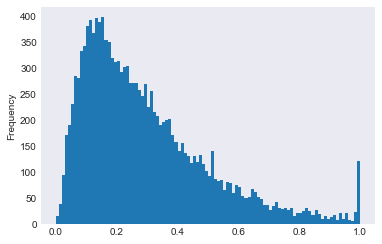

In [22]:
# some plots
route_city_metrics['norm_length'].plot.hist(bins=100);

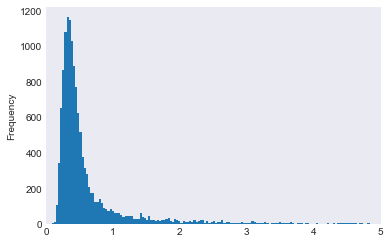

In [16]:
route_city_metrics['norm_stops'].plot.hist(bins=1000, xlim=(0,5));

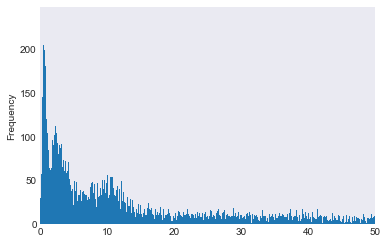

In [17]:
route_city_metrics['city_norm_curve'].loc[route_city_metrics['city_norm_curve'] < 100].plot.hist(bins=1000, xlim=(0,50));

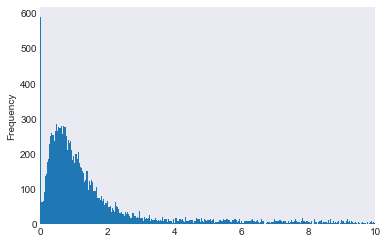

In [18]:
route_city_metrics['norm_turns'].plot.hist(bins=1000, xlim=(0,10));

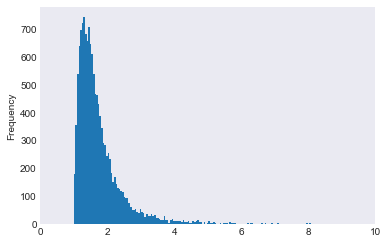

In [19]:
route_city_metrics['sinuocity'].loc[route_city_metrics['sinuocity'] < 100].plot.hist(bins=1000, xlim=(0,10))

## Cluster Analysis

Create clusters of bus routes and cities and analyse them

### Clusters for all Routes

First create Silhouette plots so we know how many clusters to choose

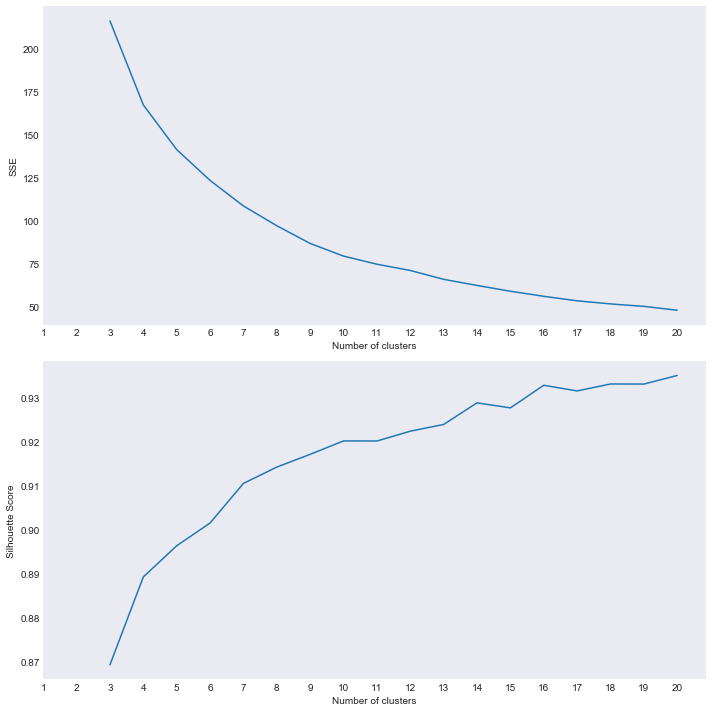

In [23]:
fig = plt.figure(figsize=(10,10))
ss= fig.add_subplot(2,1,1)
si = fig.add_subplot(2,1,2)

n_clusters = 3

sse = {}
sil = {}

while n_clusters <= 20:
    
    # attributes = ['norm_length', 'norm_stops', 'norm_curve', 'sinuocity'] # normalised features
    attributes = ['route_length','norm_stops','sinuocity','city_norm_curve','norm_turns']
    clus_data_raw = route_city_metrics[attributes]

    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(clus_data_raw)        
    clus_data = pd.DataFrame(np_scaled, columns=attributes)

    clus_data = clus_data.set_index(route_city_metrics.index)

    clusterer = KMeans(n_clusters=n_clusters)
    clusterer.fit(clus_data)

    labels = clusterer.predict(clus_data)    
    clus_data['label'] = labels
    
    sil[n_clusters] = metrics.silhouette_score(clus_data, labels, metric='euclidean')
    sse[n_clusters] = clusterer.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

    n_clusters += 1

ss.plot(list(sse.keys()), list(sse.values()))
si.plot(list(sil.keys()), list(sil.values()))

    
# elbow plot
ss.set_xlabel("Number of clusters")
ss.set_ylabel("SSE")

si.set_xlabel("Number of clusters")
si.set_ylabel("Silhouette Score")

si.set_xticks( range(1, 21))
ss.set_xticks( range(1, 21))
plt.tight_layout()
plt.show()



**IMPORTANT: Decide on the number of clusters**

In [28]:
n_clusters = 7
md("{} clusters are chosen because this is when the Silhouette plot starts to plateau".format(n_clusters))

7 clusters are chosen because this is when the Silhouette plot starts to plateau

Now create the clusters

In [30]:

attributes = ['route_length','norm_stops','sinuocity','city_norm_curve','norm_turns']
clus_data_raw = route_city_metrics[attributes]

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(clus_data_raw)        
clus_data = pd.DataFrame(np_scaled, columns=attributes)

clus_data = clus_data.set_index(route_city_metrics.index)

clusterer = KMeans(n_clusters=n_clusters)
#clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=2434533)
clusterer.fit(clus_data)

labels = clusterer.predict(clus_data)
        
clus_data['label'] = labels
        
# s_filename = '/Users/edmanley/Dropbox/bus_analysis/global_routes/clusters/all_cities/km_labels_%s_stats.txt' % (n_clusters)
# stats = open(s_filename, 'w')
label_count = 0
while label_count < n_clusters:
    subset = clus_data.loc[clus_data.label == label_count]
    subset = subset[attributes]
    print('CLUSTER ' + str(label_count))
    print(str(subset.describe()))
    
#     stats.write('CLUSTER ' + str(label_count) + '\n')
#     stats.write(str(subset.describe()) + '\n')
#     stats.write('\n')
    label_count += 1
# stats.close()

# fname = '/Users/edmanley/Dropbox/bus_analysis/global_routes/clusters/cities/km_%s_res.txt' % (n_clusters)
# clus_data.to_csv(fname, ',')



CLUSTER 0
       route_length  norm_stops   sinuocity  city_norm_curve  norm_turns
count    646.000000  646.000000  646.000000       646.000000  646.000000
mean       0.130632    0.012146    0.027168         0.221904    0.117190
std        0.074381    0.013373    0.062205         0.078749    0.056782
min        0.002385    0.002275    0.000792         0.103290    0.000000
25%        0.075353    0.007338    0.008220         0.162446    0.076974
50%        0.116986    0.009359    0.014721         0.200605    0.102165
75%        0.172048    0.011746    0.024881         0.262952    0.146257
max        0.394076    0.166630    0.767221         0.517636    0.317090
CLUSTER 1
       route_length   norm_stops     sinuocity  city_norm_curve   norm_turns
count   3913.000000  3913.000000  3.913000e+03      3913.000000  3913.000000
mean       0.217089     0.026248  1.591060e-02         0.025728     0.027213
std        0.043033     0.039208  1.799483e-02         0.031129     0.022594
min        0.12

Also look at the average values across all routes; this tells you whether a particular cluster has a higher or lower value for a variable than the mean.

In [31]:
clus_data.describe()

,route_length,norm_stops,sinuocity,city_norm_curve,norm_turns,label
count,13900.000000,13900.000000,13900.000000,13900.000000,13900.000000,13900.000000
mean,0.170690,0.025035,0.018477,0.034382,0.054438,3.843669
std,0.129515,0.048571,0.039753,0.064852,0.069830,2.292787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.088069,0.008352,0.006469,0.003264,0.015896,1.000000
50%,0.137038,0.011583,0.011600,0.011381,0.029844,4.000000
75%,0.213730,0.019058,0.020119,0.039644,0.056378,6.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [32]:
clus_data.groupby(by='label')['route_length'].count().sort_values()

label
2      37
5     254
0     646
3    1170
4    1310
1    3913
6    6570
Name: route_length, dtype: int64

In [33]:
# cluster summary stats
for i in range(n_clusters):
    print(i,"\n",clus_data[['route_length','norm_stops','city_norm_curve','norm_turns','sinuocity']].
          loc[clus_data['label'] == i].mean())


0 
 route_length       0.130632
norm_stops         0.012146
city_norm_curve    0.221904
norm_turns         0.117190
sinuocity          0.027168
dtype: float64
1 
 route_length       0.217089
norm_stops         0.026248
city_norm_curve    0.025728
norm_turns         0.027213
sinuocity          0.015911
dtype: float64
2 
 route_length       0.138846
norm_stops         0.009477
city_norm_curve    0.720317
norm_turns         0.434837
sinuocity          0.009055
dtype: float64
3 
 route_length       0.401107
norm_stops         0.061016
city_norm_curve    0.027093
norm_turns         0.023133
sinuocity          0.014546
dtype: float64
4 
 route_length       0.127207
norm_stops         0.012419
city_norm_curve    0.022251
norm_turns         0.223808
sinuocity          0.021431
dtype: float64
5 
 route_length       0.741798
norm_stops         0.208747
city_norm_curve    0.017206
norm_turns         0.013084
sinuocity          0.008509
dtype: float64
6 
 route_length       0.092731
norm_stops    

Cluster profiles:

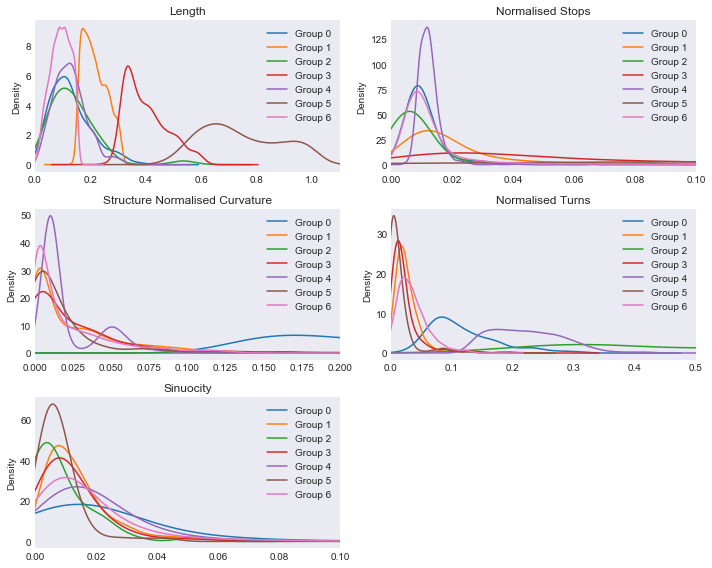

In [34]:
fig = plt.figure(figsize=(10,8))
length= fig.add_subplot(3,2,1)
norm_stops = fig.add_subplot(3,2,2)
city_norm_curve = fig.add_subplot(3,2,3)
norm_turns = fig.add_subplot(3,2,4)
sinuocity = fig.add_subplot(3,2,5)

length.set_title('Length')
norm_stops.set_title('Normalised Stops')
city_norm_curve.set_title('Structure Normalised Curvature')
norm_turns.set_title('Normalised Turns')
sinuocity.set_title('Sinuocity')

#legend = ['Group 0', 'Group 1','Group 2','Group 3','Group 4' ]#,'Group 5'] # 'Group 6', 'Group 7', 'Group 8', 'Group 9']
legend = ['Group '+str(i) for i in range(n_clusters)]

for variable_name, legend_object, _xlim in [('route_length',length,[0,1.1]), ('norm_stops', norm_stops, [0,0.1]), \
                                            ('city_norm_curve', city_norm_curve,[0,0.2]), ('norm_turns',norm_turns,[0,0.5]),\
                                            ('sinuocity',sinuocity,[0,0.1]) ]:
    
    for i in range(n_clusters):
        clus_data[[variable_name]].loc[clus_data['label'] == i].plot.kde(label='Group '+str(i),ax=legend_object)
        
    legend_object.legend(legend)
    legend_object.set_xlim(_xlim)
    


plt.tight_layout()
plt.show()


#fig.savefig(fname="cluster_profiles.pdf", bbox_inches='tight')
#fig.savefig(fname="../abstract/figures/cluster_profiles.pdf", bbox_inches='tight')

In [35]:
# rejoin data with cluster labels
route_city_clusters = pd.concat([clus_data, route_city_metrics], axis=1)

In [36]:
prop_clusters = route_city_clusters.pivot_table(index=['location'], columns=['label'], 
                                                values=['city'], aggfunc='count')
prop_clusters = prop_clusters.fillna(0)
prop_clusters = prop_clusters.div(prop_clusters.sum(1), axis=0)
prop_clusters.head()


city                                                            
label                                         0         1         2         3         4         5         6
location                                                                                                   
Aachen, Germany                        0.000000  0.220930  0.000000  0.058140  0.017442  0.005814  0.697674
Adelaide SA, Australia                 0.006757  0.375000  0.000000  0.121622  0.000000  0.000000  0.496622
Atlanta, GA, USA                       0.020000  0.293333  0.000000  0.180000  0.000000  0.066667  0.440000
Auckland, New Zealand                  0.000000  0.106628  0.000000  0.028818  0.809798  0.000000  0.054755
Austin, TX, USA                        0.000000  0.323529  0.000000  0.088235  0.000000  0.019608  0.568627
Bakersfield, CA, USA                   0.000000  0.379310  0.000000  0.172414  0.000000  0.344828  0.103448
Bilbao, Biscay, Spain                  0.000000  0.233333  0.000000  0.400000  0.200000  0.000000  0.166667
Boise, ID, USA                         0.161290  0.064516  0.000000  0.161290  0.000000  0.000000  0.612903
Boston, MA, USA                        0.000000  0.158879  0.000000  0.046729  0.000000  0.028037  0.766355
Brisbane QLD, Australia                0.000000  0.433735  0.000000  0.144578  0.000000  0.056225  0.365462
Bronx, NY, USA                         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000
Brooklyn, NY, USA                      0.000000  0.127273  0.000000  0.000000  0.000000  0.000000  0.872727
Brussels, Belgium                      0.000000  0.021053  0.000000  0.000000  0.000000  0.000000  0.978947
Budapest, Hungary                      0.000000  0.030137  0.000000  0.010959  0.846575  0.000000  0.112329
Buffalo, NY, USA                       0.428571  0.142857  0.285714  0.142857  0.000000  0.000000  0.000000
Calgary, AB, Canada                    0.011765  0.407843  0.000000  0.039216  0.000000  0.000000  0.541176
Canberra ACT, Australia                0.000000  0.532609  0.000000  0.163043  0.000000  0.000000  0.304348
Chicago, IL, USA                       0.478261  0.043478  0.293478  0.021739  0.000000  0.000000  0.163043
Christchurch, New Zealand              0.000000  0.565217  0.000000  0.130435  0.000000  0.000000  0.304348
Cleveland, OH, USA                     0.019231  0.596154  0.000000  0.038462  0.000000  0.000000  0.346154
Columbus, OH, USA                      0.000000  0.627907  0.000000  0.209302  0.000000  0.000000  0.162791
Dallas, TX, USA                        0.062112  0.391304  0.000000  0.043478  0.000000  0.006211  0.496894
Denver, CO, USA                        0.521739  0.161491  0.006211  0.173913  0.000000  0.068323  0.068323
Detroit, MI, USA                       0.025000  0.650000  0.000000  0.125000  0.000000  0.000000  0.200000
Dublin, Ireland                        0.000000  0.622642  0.000000  0.113208  0.000000  0.000000  0.264151
Durham, NC, USA                        0.000000  0.439394  0.000000  0.090909  0.000000  0.045455  0.424242
Edmonton, AB, Canada                   0.256410  0.307692  0.008547  0.008547  0.000000  0.008547  0.410256
El Paso, TX, USA                       0.000000  0.357143  0.000000  0.051020  0.000000  0.020408  0.571429
Eugene, OR, USA                        0.812500  0.125000  0.000000  0.000000  0.000000  0.000000  0.062500
Florence, Italy                        0.000000  0.083333  0.000000  0.000000  0.023810  0.000000  0.892857
Fort Lauderdale, FL, USA               0.020408  0.591837  0.000000  0.346939  0.000000  0.040816  0.000000
Grenoble, France                       0.000000  0.117647  0.000000  0.000000  0.000000  0.000000  0.882353
Halifax, NS, Canada                    0.000000  0.306122  0.000000  0.061224  0.000000  0.000000  0.632653
Hamilton, ON, Canada                   0.029412  0.147059  0.029412  0.000000  0.000000  0.000000  0.794118
Hartford, CT, USA                      0.000000

Make a smaller subset of cities for the bar plot

In [38]:
# First subset is all routes except for very short ones. These are used to generat clusters.
subset_cities2 = []
with open('data/subset_cities2.txt') as file:
    for line in file: 
        line = line.strip() 
        subset_cities2.append(line)
subset_cities2 = pd.Series(subset_cities2, name='city')
subset_cities2 = subset_cities2.to_frame()

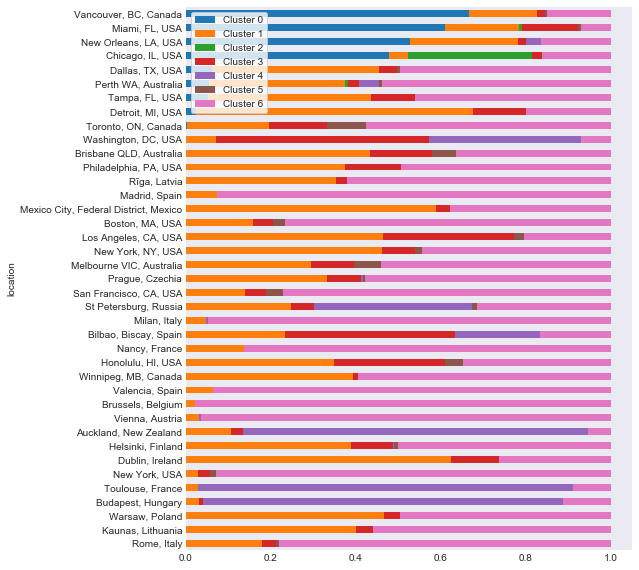

In [39]:
# For all cities:
#prop_clusters.sort_values(by=[('city',0)]).plot(kind='barh', stacked=True, figsize=(15,30), legend=False)

# For the smaller subset:
ax = prop_clusters.loc[subset_cities2['city']].sort_values(by=[('city',0)])\
    .plot(kind='barh', stacked=True, figsize=(8,10), legend=False)

ax.legend( labels=["Cluster {}".format(i) for i in range(n_clusters)], \
          loc="upper left", ncol=1, frameon = True, facecolor="white")

fig = ax.get_figure()

#fig.savefig(fname="barh.pdf", bbox_inches='tight')
#fig.savefig(fname="../abstract/figures/barh.pdf", bbox_inches='tight')

## Implications

What are the implications of this analysis for society? Can we use the analysis here, particularly that of normalised bus route entropy, to provide evidence for the impact that bus routes are having on wider societal outcomes (ranging from satisfaction with public transport to broader quality-of-life indicators). Basically are there any meaninngful relationships between the entropy measures and x.

Possible factors to explore:

 - `[X]` [pollution](#Pollution)
 
 - `[X]` happiness / satisfaction with the bus route: [Moovit](#Satisfaction---Moovit)
 
 - `[ ]` [inequality (gini)](#Pollution)

 - `[ ]` usage

 - `[ ]` accessibility

 - `[ ]` quality of life, deprivation

 - `[ ]` polycentricity (vs monocebntricity)

 - `[ ]` spending (on public transport) (leads to different types of routes)

 - `[ ]` GDP

### Pollution

The WHO have created the 'Ambient Air Quality Database' in April 2018. Raw Excel data available in [./data/aap_air_quality_database_2018_v14.xlsx](./data/aap_air_quality_database_2018_v14.xlsx). I made a simplified [csv file](./data/aap_air_quality_database_2018_v14.csv).

Read those data, link to the bus route metrics, and see if there are any interesting relationships.

_Is Relative Entropy the best one to use??_

In [23]:
# link to pollution data and do some plots
pollution = pd.read_csv("./data/aap_air_quality_database_2018_v14.csv")

# Join
metrics_pollution = route_city_metrics.set_index("CityName").join(pollution.set_index("City/Town"))
metrics_pollution.head()


,city,Unnamed: 0,route_id,shape_id,sample_trip,stops,route_length,od_length,sinuocity,time,speed,curve,norm_curve,circular,major_turns,start_lon,start_lat,end_lon,end_lat,location,sha,entropy,rel_entropy,circuity,avg_degree,intersection_count,norm_length,norm_stops,city_norm_curve,norm_turns,country,Region,iso3,Country,Year,"Annual mean, ug/m3",Temporal coverage,note on converted PM2.5,Number and type of monitoring stations,Reference for air quality,Database version (year),status
Aachen,"Aachen, Germany",1306.0,10041_704,262,32856177,11.0,5.446358,3.962095,1.374615,1.0,1.0,1842.215806,338.247293,False,8.0,6.488680,50.750034,6.440289,50.731817,"Aachen, Germany",58bf41921c9695f8bfad3be2b18f7de7634b5840ed6f75...,3.576403,0.006901,1.07764,4.800668,298167.0,0.081967,0.495123,2.334271,1.468872,Germany,Europe (HIC),DEU,Germany,2015.0,11.0,NaN,Measured,2 Urban,The European Environment Agency (EEA),2018.0,NaN
Aachen,"Aachen, Germany",1307.0,10042_704,153,32856200,14.0,5.114316,3.963398,1.290387,1.0,1.0,2157.683322,421.890876,False,8.0,6.479260,50.766973,6.482206,50.802568,"Aachen, Germany",58bf41921c9695f8bfad3be2b18f7de7634b5840ed6f75...,3.576403,0.006901,1.07764,4.800668,298167.0,0.076970,0.365308,2.911502,1.564236,Germany,Europe (HIC),DEU,Germany,2015.0,11.0,NaN,Measured,2 Urban,The European Environment Agency (EEA),2018.0,NaN
Aachen,"Aachen, Germany",1308.0,10043_704,44,32856497,5.0,1.433520,1.284151,1.116317,1.0,1.0,311.337985,217.184285,False,1.0,6.482206,50.802568,6.497494,50.808895,"Aachen, Germany",58bf41921c9695f8bfad3be2b18f7de7634b5840ed6f75...,3.576403,0.006901,1.07764,4.800668,298167.0,0.021574,0.286704,1.498806,0.697584,Germany,Europe (HIC),DEU,Germany,2015.0,11.0,NaN,Measured,2 Urban,The European Environment Agency (EEA),2018.0,NaN
Aachen,"Aachen, Germany",1309.0,10044_704,121,32856567,7.0,2.099300,1.783197,1.177267,1.0,1.0,1627.409690,775.215471,False,9.0,6.500357,50.791363,6.482206,50.802568,"Aachen, Germany",58bf41921c9695f8bfad3be2b18f7de7634b5840ed6f75...,3.576403,0.006901,1.07764,4.800668,298167.0,0.031594,0.299900,5.349822,4.287144,Germany,Europe (HIC),DEU,Germany,2015.0,11.0,NaN,Measured,2 Urban,The European Environment Agency (EEA),2018.0,NaN
Aachen,"Aachen, Germany",1310.0,10045_704,258,32856650,12.0,3.939329,2.517990,1.564474,1.0,1.0,2157.409810,547.659181,False,12.0,6.482206,50.802568,6.466408,50.822894,"Aachen, Germany",58bf41921c9695f8bfad3be2b18f7de7634b5840ed6f75...,3.576403,0.006901,1.07764,4.800668,298167.0,0.059286,0.328277,3.779439,3.046204,Germany,Europe (HIC),DEU,Germany,2015.0,11.0,NaN,Measured,2 Urban,The European Environment Agency (EEA),2018.0,NaN


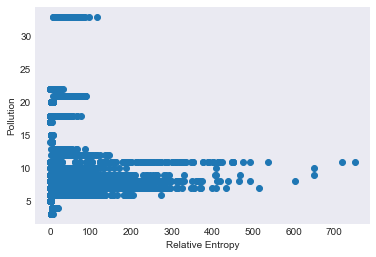

In [25]:
plt.scatter(x=metrics_pollution['city_norm_curve'], y=metrics_pollution['Annual mean, ug/m3']) # rel_entropy
plt.xlabel("Relative Entropy")
plt.ylabel("Pollution")
plt.show()

### Satisfaction - Moovit

Use the _Moovit Global Public Transport Report 2019_ [link](https://company.moovit.com/global-transport-report/) and look for correlations between satisfaction and the network factors previously calculated.

#### Read Moovit data

Although released publicly, the data were not available for a direct download so were copied from the website. They're in a weird format so deal with that first

In [26]:
header = ["Country",
          "City",
          "Transit1", #"Closer transit stations to my home/work to reduce my walking distance",
          "Transit2", #"A way to get to the station from my home (using shuttle, micro-mobility)",
          "Accurate and reliable arrival times according to the published schedule",
          "Better accessibility for people with needs (wheelchair, ramps, etc.)",
          "Cleanliness - Cleaner buses/trains and stations",
          "Comfort - Wider seats, access to WiFi, air-conditioning, charging outlets",
          "Convenient parking areas near stations for car owners",
          "Convenient ways to purchase transit tickets (mobile ticketing)",
          "Higher frequency of public transit vehicles/shorter waiting times at stations",
          "Less transfers - Having more direct lines to my destination",
          "Lower cost fares",
          "Personal safety - Feeling safer when riding public transit.",
          "Shorter trip duration time (less congestion)",
          "Uncrowded - Vehicles that are not overly packed"]

with open("./data/moovit_survey_raw.csv") as f:
    # The file is one long column so need to read over it and organise into a table
    count = 0 # keep a count so we know when we have reaached a new row
    table = [] # each item in this array will be a row (another array)
    row = []
    for line in f:
        line = line.strip().replace('%','') # Gets rid of percent signs
        if line =="": # Ignore blank lines
            continue
        if count == len(header): # Have read a whole row. Restart
            count = 0
            table.append(row)
            #print(row)
            row = []
        # Have a data item. If it can be converted, make it a number
        try:
            number = float(line)
            row.append(number)
        except ValueError:
            row.append(line) # Not a number. Probably a city/country name
        count += 1

moovit = pd.DataFrame(table, columns=header)
moovit.head()

,Country,City,Transit1,Transit2,Accurate and reliable arrival times according to the published schedule,"Better accessibility for people with needs (wheelchair, ramps, etc.)",Cleanliness - Cleaner buses/trains and stations,"Comfort - Wider seats, access to WiFi, air-conditioning, charging outlets",Convenient parking areas near stations for car owners,Convenient ways to purchase transit tickets (mobile ticketing),Higher frequency of public transit vehicles/shorter waiting times at stations,Less transfers - Having more direct lines to my destination,Lower cost fares,Personal safety - Feeling safer when riding public transit.,Shorter trip duration time (less congestion),Uncrowded - Vehicles that are not overly packed
0,﻿France,Paris,25.1,13.5,42.7,13.2,28.7,25.4,13.1,13.4,37.6,29.5,27.9,27.9,38.6,18.8
1,Canada,Toronto,25.3,17.3,46.8,17.0,25.1,31.0,13.6,17.7,51.2,28.4,44.9,23.5,40.2,35.8
2,France,Nice & Cannes,25.8,13.8,48.0,8.0,17.2,20.4,10.7,13.1,41.2,30.8,23.1,19.3,34.0,20.2
3,France,Marseille & Provence,25.8,14.9,45.4,11.1,18.2,22.2,10.9,20.6,34.8,28.1,29.3,18.0,40.0,17.0
4,USA,Los Angeles,25.9,17.6,38.8,13.4,30.0,29.9,10.7,19.2,43.9,25.1,33.1,32.9,35.2,25.9


#### Moovit - Entropy analysis

Look for relationship between satisfaction (from Moovit data) and relative entropy (_should this be entropy difference?_)

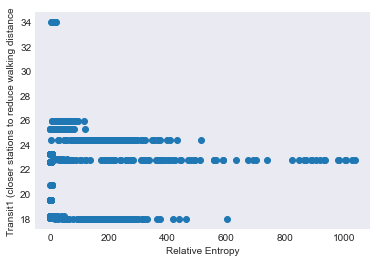

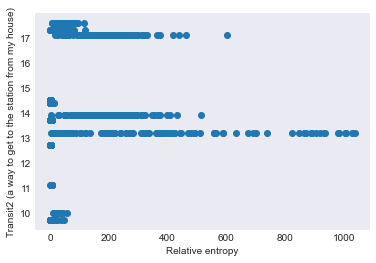

In [27]:
# join to the metrics data

metrics_moovit = route_city_metrics.set_index("CityName").join(moovit.set_index("City"))

plt.scatter(x=metrics_moovit['city_norm_curve'], y=metrics_moovit['Transit1'])
plt.xlabel("Relative Entropy")
plt.ylabel("Transit1 (closer stations to reduce walking distance")
plt.show()
#plt.scatter(x=entrophy_moovit['sne_rel'], y=entrophy_moovit['Transit1'])
#plt.show()
#plt.scatter(x=entrophy_moovit['bne_rel'], y=entrophy_moovit['Transit1'])
#plt.show()

plt.scatter(x=metrics_moovit['city_norm_curve'], y=metrics_moovit['Transit2'])
plt.xlabel("Relative entropy")
plt.ylabel("Transit2 (a way to get to the station from my house)")
plt.show()
#plt.scatter(x=entrophy_moovit['sne_rel'], y=entrophy_moovit['Transit2'])
#plt.show()
#plt.scatter(x=entrophy_moovit['bne_rel'], y=entrophy_moovit['Transit2'])
#plt.show()

### Inequality

Can get Gini measures by country but not city.

Could focus on American cities using the 2019 American Community Survey. E.g. see [blog post](https://www.usnews.com/news/cities/articles/2020-09-21/us-cities-with-the-biggest-income-inequality-gaps) or [dashboard (with data)](https://apps.urban.org/features/inclusion/index.html)

Or on British cities  https://doi.org/10.1080/00343404.2015.1053859  


#### Inequality in American cities

 - Data: [Measuring Inclusion in America’s Cities](https://apps.urban.org/features/inclusion/data/measuring-inclusion-data.xlsx)
 - Explanation: [website](https://apps.urban.org/features/inclusion/index.html?topic=map)

In [ ]:
# Just get the Z-score, raw number, and rank for 'Income Segregation (2016)'
us_ineq = pd.read_excel(os.path.join("data", "measuring-inclusion-data.xlsx"),
                        sheet_name="Data",
                        header=None,
                        names=["Place", "State", "IncSegRaw", "IncSegZScore", "IncSegRank"],
                        usecols="A:B,GW:GY",
                        skiprows=2,
                       )
us_ineq

In [ ]:
XXXX HERE LINK TO BUS DATA